## Text Feature Extractor
this notebook generates for each text some additional/handcrafted features characterizing its named entity composition and their relative relative position (entity distance):distance is the number of words separating 2 entities (it can be negative)
* number of sentences
* number of words
* distinct count of drug name entities
* distinct count of active ingredient entities
* count of question marks (typically to identify specifically multi-intent label)
* individual count of interrogative pronoun entities (one column per pronoun: quand, qui, quoi, ou, comment, pourquoi, combien, quel(s|le,..)
* distinct count of time entities (eg: jours, après midi, soir, année, 12h, mardi, samedi, temps....)
* distinct count of quantity entities (eg: 5mg, 10ml, ...)
* count of association entities (eg: et, avec, ou, ...)
* distance between interrogative pronoun and drug name entities
* distance between active ingredient and drug name entities
* distance between quantity and drug name entities
* distance between time and drug name entities
* distance between question marks and drug name entities

In addition, we compute the likelihood of the document to be part of the **topics identified earlier by NMF **:
*  this probability is basically the ratio of matching top word over the total count

eg: topic1 is characterized by 10 top words (A, B, C, D, ....)

if the text contains words B and E, the  topic likelihood would be 2 / 10 = 1 /5

these extracted features are stored into this [file](../../data/staging_data/text_extracted_features.csv) with ID column to join it with the former train dataset if required.

In [19]:
import pandas as pd
import numpy as np

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_stemmed_clean_input_train.csv', sep=',')

In [20]:
from collections import Counter
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def words(text):
    return re.findall(r'\w+', text.lower())

# value domain based named entities
drugNames = set(words(open('../../data/staging_data/drug_names.txt').read()))
ingredientNames = set(words(open('../../data/staging_data/ingredient_names.txt').read()))

# reg expression based named entities
questionMarkRegEx = r"[\?]+"
compiledquestionMarkRegEx = re.compile(questionMarkRegEx)

sentenceSeparatorRegEx = r"[\?]+|!|:|;|[\.]+"
#quiRegEx = r"[\s\?\.\!\:\;]?[Q|q]ui\s" qui term is ambiguous
combienRegEx = r"[\s\?\.\!\:\;]?[C|c]ombien\s"
pourquoiRegEx = r"[\s\?\.\!\:\;]?[P|p]ourquoi\s"
quandRegEx = r"[\s\?\.\!\:\;]?[Q|q]uand\s"
quoiRegEx = r"[\s\?\.\!\:\;]?[Q|q]uoi\s|[\s\?\.\!\:\;]?[Q|q]uel[l|s|le|les]?\s"
commentRegEx = r"[\s\?\.\!\:\;]?[C|c]omment\s"
interrogativePronounRegEx = combienRegEx + '|' + pourquoiRegEx + '|' + quandRegEx + '|' + quoiRegEx + '|' + commentRegEx
compiledPronounRegEx = re.compile(interrogativePronounRegEx)

# associative entity
ouRegEx = r"\sou\s"
etRegEx = r"\set\s"
avecRegEx = r"\savec\s"


# gold standard
timeRegEx = r"([D|d]emain|[H|h]ier|[M|m]atin|[M|m]idi|[S|s]oir|mois|jours|jour|[D|d]epuis|semaine[s|S]|heure[s|S]|temps)( )*( |,|\.)"
quantityRegEx = r"[0-9]+\s?[m|k]?g|\s[m|k]?g[^a-zA-Zéàèî]|[0-9]+\s?[m|c]?l|\s[m|c]?l[^a-zA-Zéàèî]"

def getWordCount(text):
    words = word_tokenize(text, language='french')
    return len(words)

def getEntityCount(text, entityValueSet, lowerCase):
    ''' return distinct count of entity occurrences found from the text'''
    words = word_tokenize(text, language='french')
    if lowerCase:
        words = map(lambda x: x.lower(), words)
    return len(list(set(words) & entityValueSet))

def countWordsBefore(text, lastPosition):
    ''' count number of words before this position'''
    text = text[0:lastPosition]
    words = word_tokenize(text, language='french')
    return len(words)

def getWordIndexByReg(text, regEx):
    ''' return the word index of the first group matching the regexp'''
    iterables = list(regEx.finditer(text))
    positions = list(map(lambda x : x.span()[0], iterables))
    if len(positions) > 0:
        position = int(positions[0])
        return countWordsBefore(text, position)
    else:
        return None

def getWordIndexByValueSet(text, valueSet):
    ''' return the word index of the first token part of the value domain'''
    words = word_tokenize(text, language='french')
    wordIndex = 0
    for word in words:
        if word in valueSet:
            return wordIndex
        wordIndex = wordIndex + 1
    return None

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jacques\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
XTrain['drugCount'] = XTrain['question'].map(lambda text: getEntityCount(text, drugNames, True))
XTrain['ingredientCount'] = XTrain['question'].map(lambda text: getEntityCount(text, ingredientNames, True))

In [22]:
XTrain['timeCount'] = XTrain['question'].map(lambda text : len(re.findall(timeRegEx, text)))
XTrain['quantitiesCount'] = XTrain['question'].map(lambda text : len(re.findall(quantityRegEx, text)))
XTrain['questionMarkCount'] = XTrain['question'].map(lambda text : len(re.findall(questionMarkRegEx, text)))
XTrain['sentenceCount'] = XTrain['question'].map(lambda text : 1 + len(re.findall(sentenceSeparatorRegEx, text)))
XTrain['wordCount'] = XTrain['question'].map(lambda text : getWordCount(text))

In [23]:
XTrain['combienCount'] = XTrain['question'].map(lambda text : len(re.findall(combienRegEx, text)))
XTrain['pourquoiCount'] = XTrain['question'].map(lambda text : len(re.findall(pourquoiRegEx, text)))
XTrain['quandCount'] = XTrain['question'].map(lambda text : len(re.findall(quandRegEx, text)))
XTrain['quoiCount'] = XTrain['question'].map(lambda text : len(re.findall(quoiRegEx, text)))
XTrain['commentCount'] = XTrain['question'].map(lambda text : len(re.findall(commentRegEx, text)))

In [24]:
XTrain['avecCount'] = XTrain['question'].map(lambda text : len(re.findall(avecRegEx, text)))
XTrain['etCount'] = XTrain['question'].map(lambda text : len(re.findall(etRegEx, text)))
XTrain['ouCount'] = XTrain['question'].map(lambda text : len(re.findall(ouRegEx, text)))

In [25]:
XTrain['interrogative_WordIndex'] = XTrain['question'].map(lambda text : getWordIndexByReg(text, compiledPronounRegEx))
XTrain['questionMark_WordIndex'] = XTrain['question'].map(lambda text : getWordIndexByReg(text, compiledquestionMarkRegEx))

In [26]:
XTrain['drug_WordIndex'] = XTrain['question'].map(lambda text : getWordIndexByValueSet(text, drugNames))
XTrain['drug_InterrogativeDistance'] = XTrain['interrogative_WordIndex'] - XTrain['drug_WordIndex']
XTrain['drug_QuestionMarkDistance'] = XTrain['questionMark_WordIndex'] - XTrain['drug_WordIndex']

In [27]:
pd.set_option("display.max_colwidth",1000)
XTrain.drop(["question"], axis=1).head(5)

,ID,drugCount,ingredientCount,timeCount,quantitiesCount,questionMarkCount,sentenceCount,wordCount,combienCount,pourquoiCount,...,quoiCount,commentCount,avecCount,etCount,ouCount,interrogative_WordIndex,questionMark_WordIndex,drug_WordIndex,drug_InterrogativeDistance,drug_QuestionMarkDistance
0,0,0,1,4,0,0,5,52,0,0,...,0,0,0,3,0,NaN,NaN,NaN,NaN,NaN
1,1,1,0,0,0,1,2,6,0,0,...,0,0,0,0,0,NaN,5.0,0.0,NaN,5.0
2,2,1,0,0,0,1,5,43,0,0,...,0,0,0,1,0,NaN,42.0,3.0,NaN,39.0
3,3,0,0,0,0,1,2,7,0,0,...,0,0,0,0,0,NaN,6.0,NaN,NaN,NaN
4,4,1,1,0,0,1,3,16,0,0,...,0,0,0,1,0,NaN,15.0,7.0,NaN,8.0


In [28]:
XTrain.describe()

,ID,drugCount,ingredientCount,timeCount,quantitiesCount,questionMarkCount,sentenceCount,wordCount,combienCount,pourquoiCount,...,quoiCount,commentCount,avecCount,etCount,ouCount,interrogative_WordIndex,questionMark_WordIndex,drug_WordIndex,drug_InterrogativeDistance,drug_QuestionMarkDistance
count,8028.000000,8028.000000,8028.000000,8028.000000,8028.000000,8028.000000,8028.000000,8028.000000,8028.000000,8028.000000,...,8028.000000,8028.000000,8028.000000,8028.000000,8028.000000,1929.000000,7695.000000,4745.000000,1123.000000,4562.000000
mean,4013.500000,0.664051,0.210887,0.473717,0.069258,1.069382,2.600399,12.519681,0.040359,0.009093,...,0.154833,0.030269,0.080967,0.388142,0.080593,6.335925,10.555945,2.830348,3.554764,8.583516
std,2317.628314,0.644180,0.493128,1.109966,0.324931,0.448181,1.475605,16.434929,0.199951,0.098788,...,0.379909,0.179157,0.306357,0.800255,0.302981,13.392850,13.408257,4.426047,13.709014,13.968602
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-40.000000,-31.000000
25%,2006.750000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,-3.000000,2.000000
50%,4013.500000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,7.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,2.000000,-1.000000,4.000000
75%,6020.250000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,14.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,7.000000,12.000000,4.000000,5.000000,9.000000
max,8027.000000,8.000000,5.000000,15.000000,9.000000,8.000000,43.000000,502.000000,3.000000,2.000000,...,4.000000,3.000000,5.000000,11.000000,5.000000,192.000000,431.000000,86.000000,149.000000,388.000000


### topic likelihood features

Use NMF to extract 50 topics from the text corpus

In [29]:
topicTopWords = pd.read_csv('../../data/staging_data/topic_top_words.csv')
nbTopWords = len(topicTopWords.columns) - 1
nbTopics = len(topicTopWords)
# build a dictionary with topic id as key and bag of top words as value
dictOfBagTopWords = dict()

for row in topicTopWords.iterrows():    
    topic_id = row[1]['topic_id']
    values = row[1].values
    dictOfBagTopWords[values[0]] = set (values[1:])

In [30]:
import sys
sys.path.append('..')
from utils import textcleaner
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

frenchStopWords = set(stopwords.words("french"))

topicLikelihoods = []

for text in XTrain.question.values:        
    bagOfWords = set(textcleaner.cleanText(text, frenchStopWords).split())
    topiclikelihoodRow = [None] * nbTopics
    for topic_id, topicBagOfTopWords in dictOfBagTopWords.items():
        matchingCount = len(bagOfWords & topicBagOfTopWords)        
        topicLikelihoodValue = float(matchingCount)/float(nbTopWords)    
        topiclikelihoodRow[topic_id] = topicLikelihoodValue
    topicLikelihoods.append(topiclikelihoodRow)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jacques\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
names = [ 'likelihood_topic_' + str(i) for i in range(0,51)]
topicLikelihoodFrame = pd.DataFrame(topicLikelihoods, columns = names)

Check if there are correlations on the first 5 topics likehoods

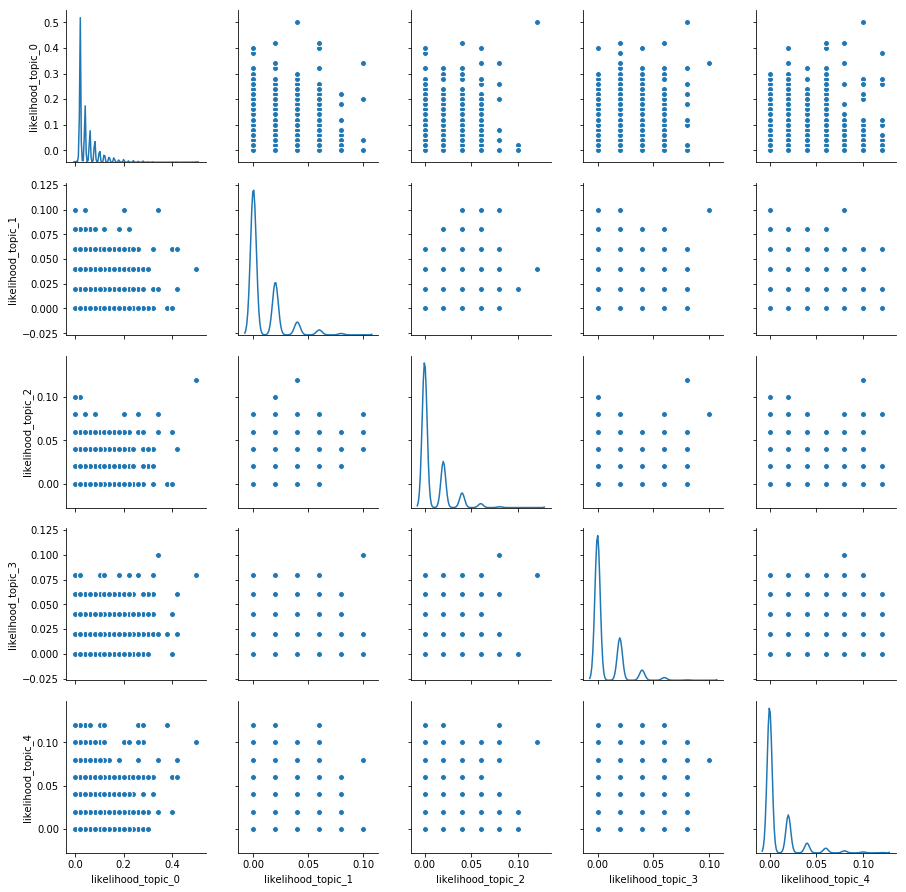

In [32]:

someTopics = topicLikelihoodFrame [['likelihood_topic_0','likelihood_topic_1','likelihood_topic_2','likelihood_topic_3','likelihood_topic_4']]

import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(someTopics, diag_kind="kde")


No linear correlation is noticeable

In [33]:
# save the extraction result
finalXTrain = XTrain.merge(topicLikelihoodFrame, left_index=True, right_index=True)

SavedTrain = finalXTrain.drop(["question"], axis=1)
SavedTrain.to_csv("../../data/staging_data/text_extracted_features.csv", index=None)
SavedTrain.head(5)

,ID,drugCount,ingredientCount,timeCount,quantitiesCount,questionMarkCount,sentenceCount,wordCount,combienCount,pourquoiCount,...,likelihood_topic_41,likelihood_topic_42,likelihood_topic_43,likelihood_topic_44,likelihood_topic_45,likelihood_topic_46,likelihood_topic_47,likelihood_topic_48,likelihood_topic_49,likelihood_topic_50
0,0,0,1,4,0,0,5,52,0,0,...,0.02,0.02,0.02,0.00,0.10,0.04,0.04,0.06,0.04,0.08
1,1,1,0,0,0,1,2,6,0,0,...,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2,1,0,0,0,1,5,43,0,0,...,0.02,0.02,0.02,0.02,0.02,0.00,0.00,0.02,0.02,0.02
3,3,0,0,0,0,1,2,7,0,0,...,0.00,0.02,0.00,0.02,0.02,0.02,0.00,0.00,0.00,0.02
4,4,1,1,0,0,1,3,16,0,0,...,0.02,0.00,0.04,0.00,0.00,0.02,0.00,0.04,0.00,0.00
